<a href="https://colab.research.google.com/github/udsey/SATO_RL/blob/main/Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install plotly==4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
import gc

# Функции

In [6]:
# Для отрисовки статического изображения в git
import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 1300
svg_renderer.height = 600
svg_renderer.engine = 'kaleido' #static image generation dependency, install it using pip or conda.

pio.renderers.default = "svg"  # set as default renderer (optional)

In [7]:
def limit_plot(df, return_df = False):
    import plotly.graph_objects as go
    df_lim = df.copy()
    df_lim['x'] = df_lim.apply(lambda x: np.arange(x[0], x[1], 0.001), axis=1)
    df_lim = df_lim.explode('x')
    df_lim.drop(columns=df_lim.columns[0:2], inplace=True)
    df_lim.rename(columns={df_lim.columns[0]:'y'}, inplace=True)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_lim.x, y=df_lim.y, name='speed limit'))
    fig.show()
    if return_df == True:
        return df_lim
def plot_stat(hist, total_reward_list):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(hist)
    plt.title('Iteration number') 
    plt.subplot(1, 2, 2)
    plt.plot(total_reward_list)
    plt.title('Total reward')      

def plot_result(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_limit_speed.x, y=df_limit_speed.y, name='speed limit'))
    fig.add_trace(go.Scatter(x = df.position, y = df.speed, name='train movement'))
    fig.show('svg')

def min_time(s, v, a=0.5):
    s*=1000
    v = v / 3.6
    t = v/a
    s_0 = a*t**2/2
    s_ost = s-s_0
    t_1 = s_ost/v
    t_min  = t+t_1
    return t_min

# Модель поезда

Состояние - позиция с точностью до метра

Действие - ускорение в диапазоне [-0.5, 0.5]

Вознграждения -

*   -1000 - движение в обратном направлении
*   -500 - превышение скорости
*   -100 - превышение лимита времени
*    +1 - движение со скоростью близкой к скоростному лимиту





In [8]:
class Train:


    def __init__(self, time_limit=2000, v_limit=100, s_limit=300, dt=10):
        self.time_limit = time_limit # s
        self.v_limit = v_limit # km/h
        self.s_limit = s_limit # km
        self.state_space = np.arange(0, self.s_limit, 0.001) # m
        self.action_space = np.arange(-0.4, 0.5, 0.1) # m/s^2
        self.dt = dt / 3600 # h
        self.df_limit = pd.DataFrame({'start': [0],
                                      'stop': [self.s_limit],
                                      'limit': self.v_limit,})

# Добавление ограничений скорости на участке

    def append_velocity_limit(self, limit, start, stop):
        self.df_limit = self.df_limit.append({'start': start,
                                              'stop': stop,
                                              'limit': limit,}, ignore_index=True)
        return self.df_limit
# Сброс скоростного ограничения к одному на всем участке
    def reset_velocity_limit(self):
        self.append_velocity_limit(self, limit=self.v_limit, 
                                   position=range(0, self.s_limit))
# Сброс окружения к начальному значению
    def reset(self):
        self.s = 0
        self.v = 0
        self.a = 0
        self.done = False
        self.total_time = 0
        self.reward = 0
        self.v_list = []
        self.s_list = []
        self.t_list = []
        self.a_list = []
        return self.s

# Возвращает скоростное ограничение на текущем участке 
    def speed_limit(self):
        if self.s < 0:
            return self.df_limit.iloc[0, 2]
    
        for i in range(self.df_limit.shape[0]):
            min_p = self.df_limit.iloc[i, 0]
            max_p = self.df_limit.iloc[i, 1]
            if min_p <= self.s <= max_p:
                return self.df_limit.iloc[i, 2]
            else:
                return min_p
# Возвращает награду в соответствии с текущим состоянием
    def reward_func(self):
        if self.s < 0: # Уехал в обратную сторону
            return -1000, True
        if self.s >= self.s_limit: # Доехал до точки назначения
            self.s = self.s_limit
            return 100, True
        if self.total_time > self.time_limit/3600: # Превысил время
            return -100, True
        if self.v > self.speed_limit(): # Превысил скорость
            return -500, True
        if self.speed_limit()/2 <= self.v <= self.speed_limit():
            return 1, False
        else:
            return 0, False
        
        

# Шаг для заданного действия
    def step(self, action):
        
        self.total_time += self.dt # h
        self.a = self.action_space[action] * (3600**2 / 1000) # km/h^2
        self.s += self.v * self.dt + (self.a * (self.dt ** 2))/2 #km
        self.v += (self.a * self.dt) # km/h
        if self.v < 0 :
            self.v = 0

        self.reward, self.done = self.reward_func()

        self.v_list.append(self.v)
        self.t_list.append(self.total_time)
        self.s_list.append(self.s)
        self.a_list.append(self.a)

        return  int(np.round(self.s, 3)*1000)-1, self.reward, self.done

# Справочная информация о движении
    def action_info(self, action):
        print('*'*20)
        print('Ускорение {:.2f} м/с^2'.format(self.action_space[action]))
        print('Скорость {:.2f} км/ч' .format(self.v)),
        print('Пройденный путь {:.6f} км'.format(self.s))
        print('Штраф', self.reward)
        print('*'*20)

# Возвращает данные о скорости на каждом участке        
    def speed_legend(self):
        df = pd.DataFrame(columns=['time', 'position', 'speed', 'acceleration'])
        df.time = self.t_list
        df.position = self.s_list
        df.speed = self.v_list
        df.acceleration = self.a_list
        return df

 

# Q-learning

In [9]:
def e_greedy(Q_table, state, epsilon):
    import random
    if random.uniform(0,1) < epsilon:
        return np.random.randint(Q_table.shape[1])
    else: 
        return np.random.choice(np.where(Q_table[state]==np.max(Q_table[state]))[0])

def q_learning_fit(env, alpha=1, gamma=1,
               epochs=1000, is_random=False, e_decay = 10000):
    
    state_space = env.state_space.shape
    action_space = env.action_space.shape

    if is_random==True:
        Q_table = np.random.rand(*(state_space + action_space))
    else:
        Q_table = np.zeros(shape = (state_space + action_space))
    hist = []
    total_reward_list = []
    epsilon = 1
    epsilon_decay_value = 0.99
    Q_table_max = []
    for epoch in range(epochs):
        if epoch> e_decay and total_reward_list[-1]>total_reward_list[-2]:
            epsilon = np.power(epsilon_decay_value, epoch - e_decay)

        state = env.reset()
        done = False
        total_reward = 0
        step = 0
        while True:
            step += 1
            prev_state = state # сохраняем предыдущее состояние
            action = e_greedy(Q_table, state, epsilon) 
            #env.action_info(action)
            state, reward, done = env.step(action) #получаем информацию
            Q_table[prev_state][action] = Q_table[prev_state][action] + \
            alpha*(reward + gamma*np.max(Q_table[state]))
            # для графиков
            total_reward += reward

            if done:
                break

        hist.append(step)
        total_reward_list.append(total_reward)


        if epoch % 500 == 0:
            print('#'*20)
            print('Epoch #', epoch, 'Reward:', total_reward)
            print()

    plot_stat(hist, total_reward_list)
    return Q_table

def q_learning_predict(Q_tab, env, total_test_episodes = 10):
    import time
    rewards = []
    for episode in range(total_test_episodes):
        state = env.reset()
        step = 0
        done = False
        total_rewards = 0
        print("****************************************************")
        print("EPISODE ", episode)
        step = 0
        reward_list = []
        while True:
            step += 1
            action = np.argmax(Q_tab[state])
            new_state, reward, done = env.step(action)
            total_rewards += reward
            reward_list.append(reward)
            if done:
                rewards.append(total_rewards)
                print("Score", total_rewards)
                print('Reward list:', reward_list)
                time.sleep(1)
                break
            state = new_state
    print ("Score over time: " +  str(sum(rewards)/total_test_episodes))

# Предсказание

In [10]:
v = 100
s = 1
t = int(min_time(s, v))*3 # Лимит по времени - в 3 раза больше минимального времени

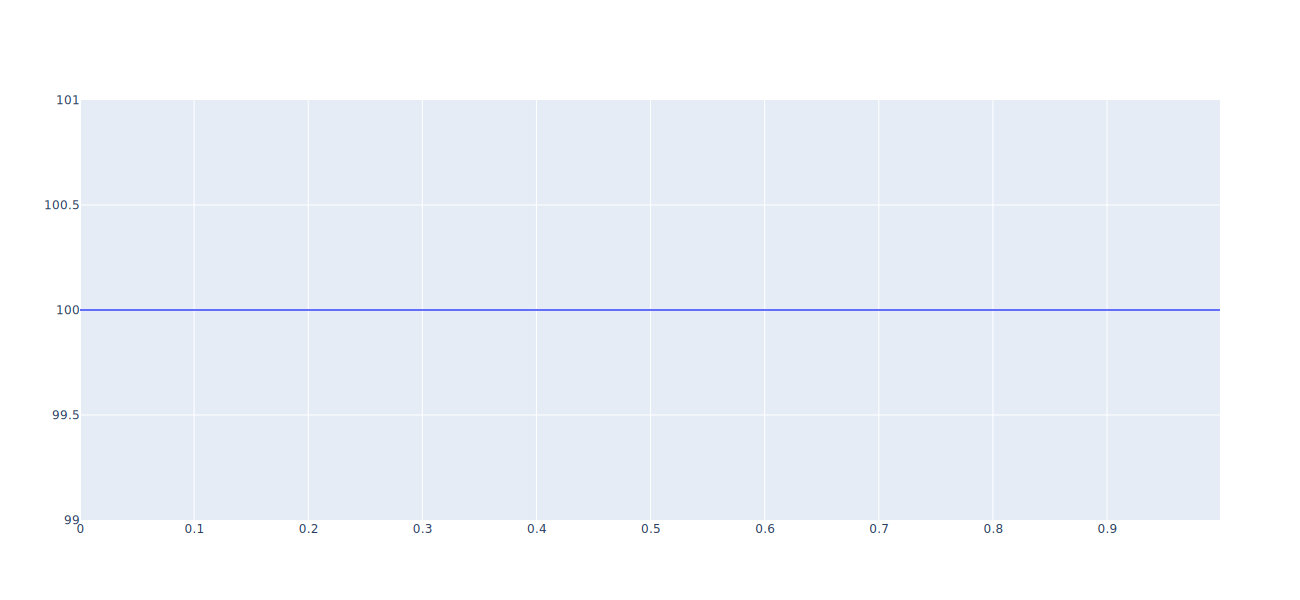

In [11]:
train = Train(s_limit=s, time_limit=t, v_limit=v, dt = 10)
train.reset()
df_limit_speed = limit_plot(train.df_limit, return_df=True)

####################
Epoch # 0 Reward: -100

####################
Epoch # 500 Reward: 102

####################
Epoch # 1000 Reward: -1000

####################
Epoch # 1500 Reward: -1000

####################
Epoch # 2000 Reward: -100

####################
Epoch # 2500 Reward: -1000

####################
Epoch # 3000 Reward: -1000

####################
Epoch # 3500 Reward: -100

####################
Epoch # 4000 Reward: -100

####################
Epoch # 4500 Reward: -100

####################
Epoch # 5000 Reward: -100

####################
Epoch # 5500 Reward: -100

####################
Epoch # 6000 Reward: 100

####################
Epoch # 6500 Reward: 104

####################
Epoch # 7000 Reward: 104

####################
Epoch # 7500 Reward: 104



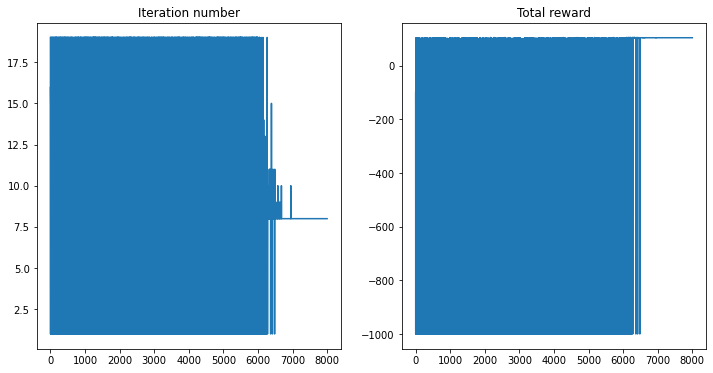

In [12]:
Q_tab= q_learning_fit(env = train, alpha=0.001, gamma=0.89,
                epochs=8000, is_random=False, e_decay=6000)

In [13]:
q_learning_predict(Q_tab, total_test_episodes = 1, env=train)

****************************************************
EPISODE  0
Score 104
Reward list: [0, 0, 0, 1, 1, 1, 1, 100]
Score over time: 104.0


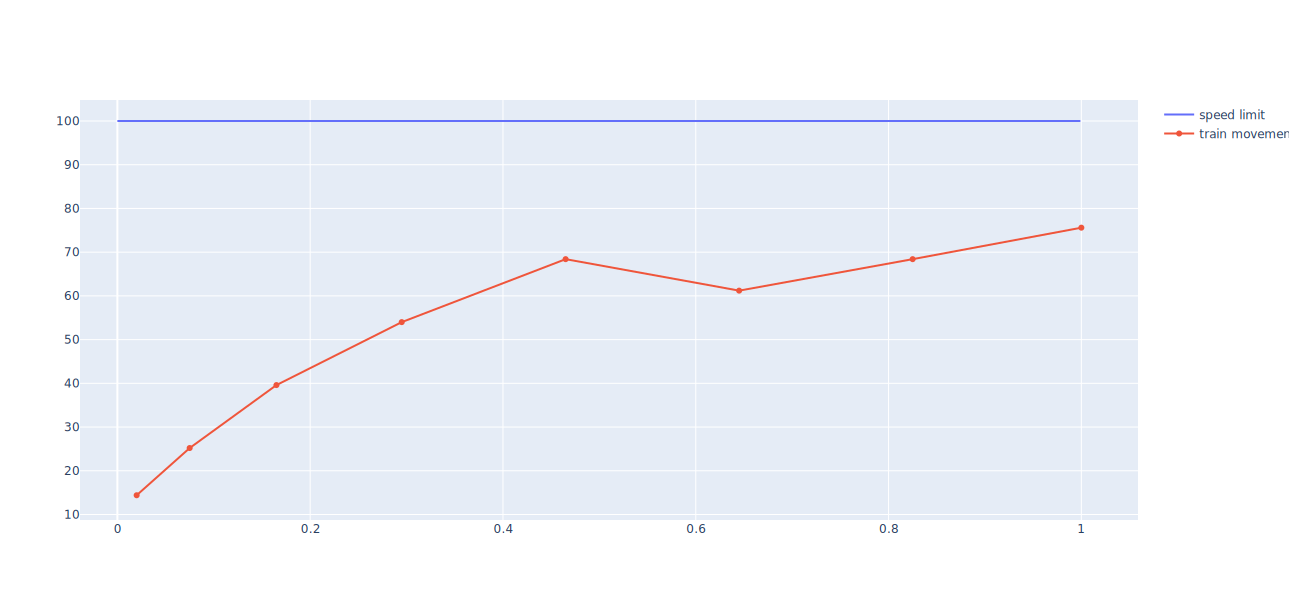

In [14]:
df = train.speed_legend()
plot_result(df)